In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# resnet with attention

Found 1200 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 0.6309 - loss: 0.6791
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.8790 - loss: 0.3175
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.9421 - loss: 0.1629
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.9993 - loss: 0.0423
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 1.0000 - loss: 0.0147
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 1.0000 - loss: 8.6863e-04
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 1.0000 - loss: 6.7759e-04
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 1.0000 - loss: 4.7937e-04
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 199m

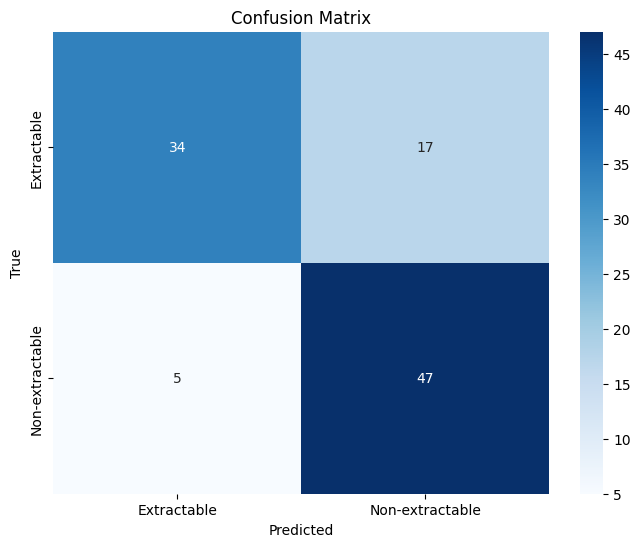

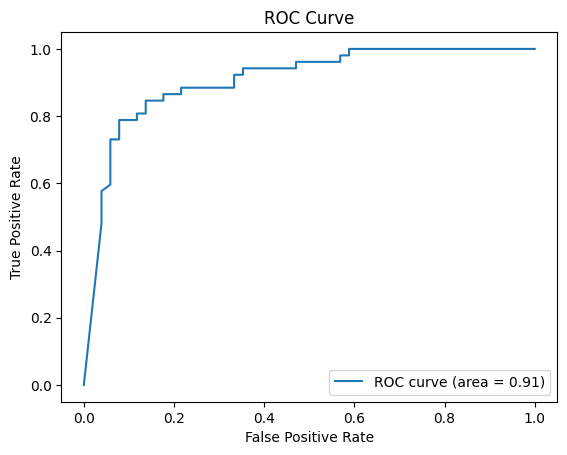

Accuracy: 0.7864077669902912
Precision: 0.734375
Recall: 0.9038461538461539
F1-Score: 0.8103448275862069
ROC AUC: 0.9074283559577677


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Multiply, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracIntroduction
y_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define paths
train_path = '/content/drive/MyDrive/augmented_cropless'
test_path = '/content/drive/MyDrive/test'
img_width, img_height = 224, 224
batch_size = 32

#Introduction
 Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Data rescaling for test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',Introduction

    shuffle=False
)

# Load pre-trained ResNet101V2 model (excluding top classification layer)
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add attention mechanism
def attention_block(inputs):
    attention = Dense(inputs.shape[-1], activation='sigmoid')(inputs)
    return Multiply()([inputs, attention])

# Add custom classification layers with attention
inputs = Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = attention_block(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=inputs, outputs=predictions)

# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=30)

# Make predictions on test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels
y_true = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")


# resnet with mobilenet

Found 1200 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.5495 - loss: 1.0111
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.8045 - loss: 0.4411
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.8251 - loss: 0.3777
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.9248 - loss: 0.2134
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.9417 - loss: 0.1622
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9713 - loss: 0.0956
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9623 - loss: 0.0881
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9825 - loss: 0.0525
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.9522 - loss: 0.1088
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9906 - loss: 0.0347
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 1.0000 - loss: 0.0092
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accu

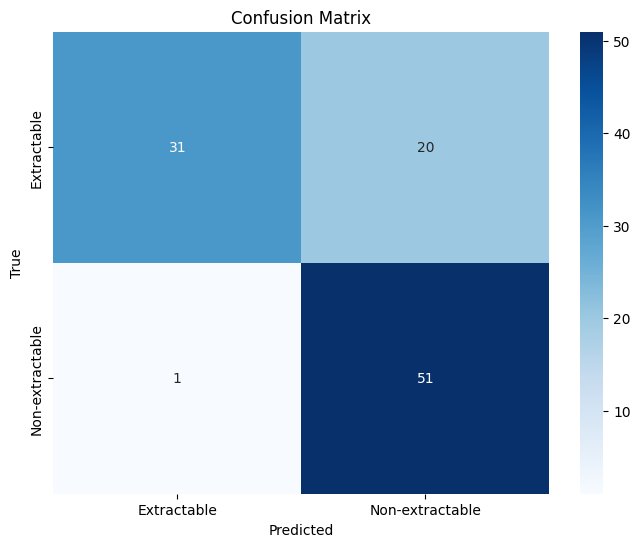

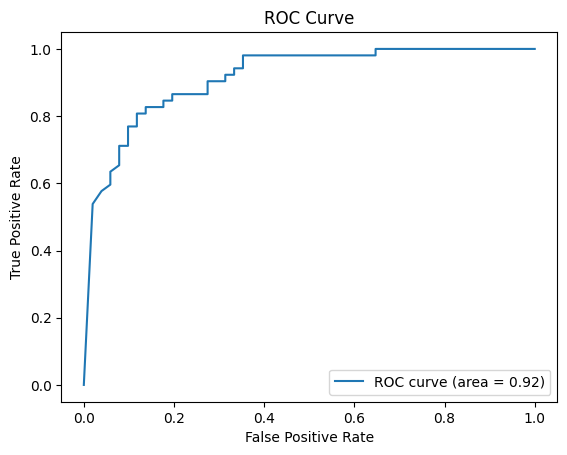

Accuracy: 0.7961165048543689
Precision: 0.7183098591549296
Recall: 0.9807692307692307
F1-Score: 0.8292682926829268
ROC AUC: 0.9155354449472096


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101V2, MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
train_path = '/content/drive/MyDrive/augmented_cropless'
test_path = '/content/drive/MyDrive/test'
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # or 'categorical' if more than two classes
)

# Data rescaling for test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary', # or 'categorical' if more than two classes
    shuffle=False # Important for ROC curve
)

# Load pre-trained ResNet101V2 model (excluding top classification layer)
resnet_base = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Load pre-trained MobileNetV2 model (excluding top classification layer)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Define model inputs
inputs = Input(shape=(img_width, img_height, 3))

# Extract features from both models
resnet_features = resnet_base(inputs)
mobilenet_features = mobilenet_base(inputs)

# Apply global average pooling to both sets of features
resnet_features = GlobalAveragePooling2D()(resnet_features)
mobilenet_features = GlobalAveragePooling2D()(mobilenet_features)

# Concatenate features
combined_features = Concatenate()([resnet_features, mobilenet_features])

# Add fully connected layers
x = Dense(512, activation='relu')(combined_features)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Build the model
hybrid_model = Model(inputs=inputs, outputs=outputs)

# Freeze layers of the base models
for layer in resnet_base.layers:
    layer.trainable = False

for layer in mobilenet_base.layers:
    layer.trainable = False

# Compile the model
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = hybrid_model.fit(train_generator, epochs=30)

# Make predictions on test set
y_pred_prob = hybrid_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels
y_true = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")


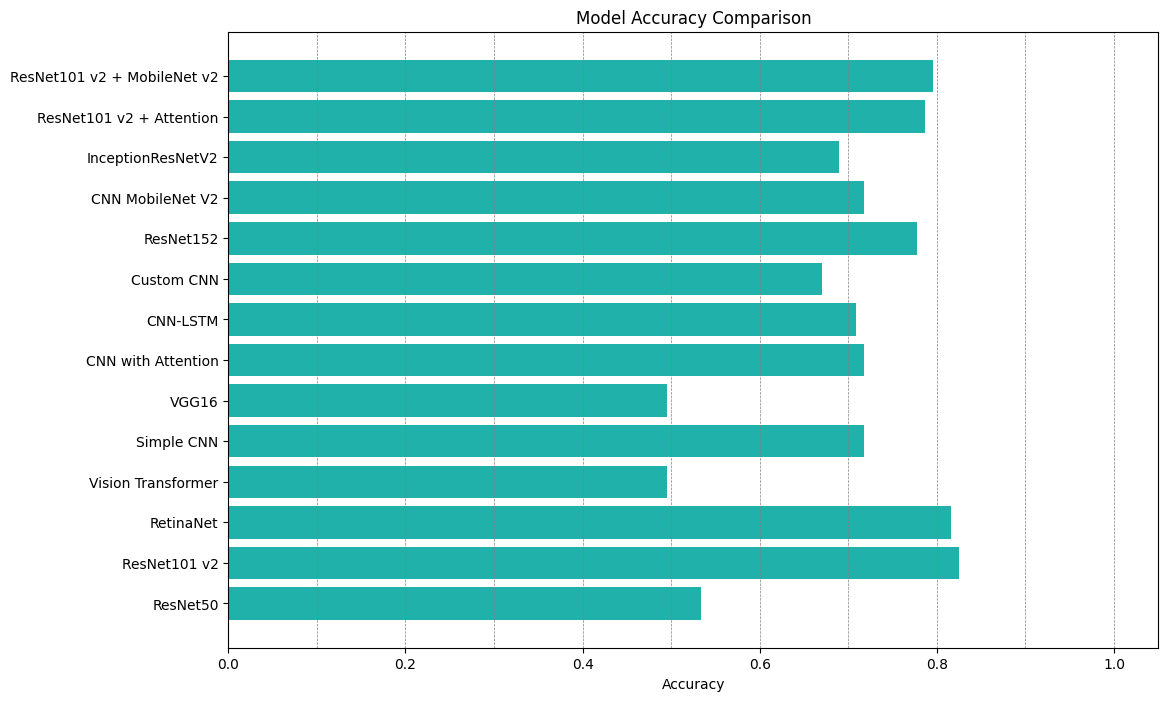

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = ['ResNet50', 'ResNet101 v2', 'RetinaNet', 'Vision Transformer', 'Simple CNN', 'VGG16',
          'CNN with Attention', 'CNN-LSTM', 'Custom CNN', 'ResNet152', 'CNN MobileNet V2', 'InceptionResNetV2',
          'ResNet101 v2 + Attention', 'ResNet101 v2 + MobileNet v2']
accuracy = [0.534, 0.825, 0.816, 0.495, 0.718, 0.495, 0.718, 0.709, 0.670, 0.777, 0.718, 0.689, 0.786, 0.796]

plt.figure(figsize=(12, 8))
plt.barh(models, accuracy, color='lightseagreen')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add dotted lines for every 0.1 increment in accuracy
for i in np.arange(0.1, 1.1, 0.1):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)

plt.show()


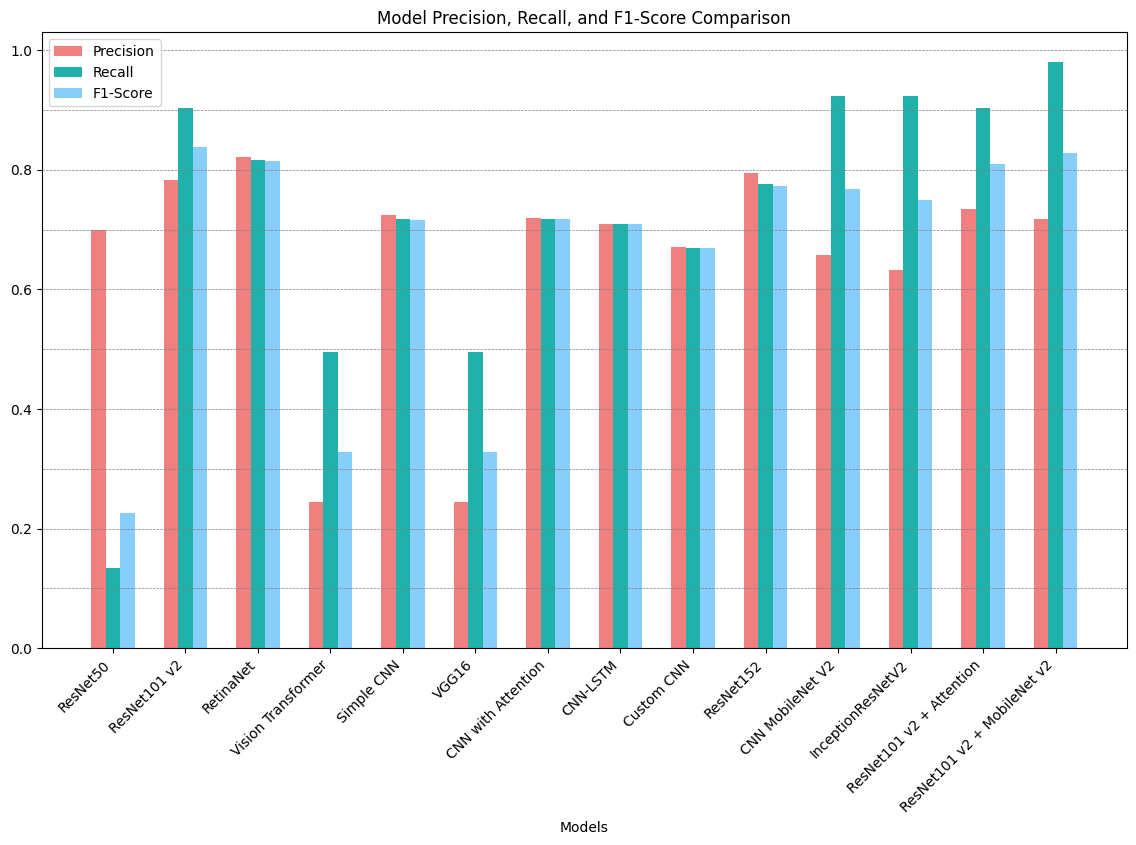

In [ ]:
import numpy as np

precision = [0.700, 0.783, 0.821, 0.245, 0.725, 0.245, 0.720, 0.709, 0.671, 0.795, 0.658, 0.632, 0.734, 0.718]
recall = [0.135, 0.904, 0.816, 0.495, 0.718, 0.495, 0.718, 0.709, 0.670, 0.777, 0.923, 0.923, 0.904, 0.981]
f1_score = [0.226, 0.839, 0.815, 0.328, 0.716, 0.328, 0.718, 0.709, 0.669, 0.773, 0.768, 0.750, 0.810, 0.829]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - width, precision, width, label='Precision', color='lightcoral')
ax.bar(x, recall, width, label='Recall', color='lightseagreen')
ax.bar(x + width, f1_score, width, label='F1-Score', color='lightskyblue')

ax.set_xlabel('Models')
ax.set_title('Model Precision, Recall, and F1-Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Add dotted lines for every 0.1 increment in y-axis
for i in np.arange(0.1, 1.1, 0.1):
    ax.axhline(y=i, color='gray', linestyle='--', linewidth=0.5)

plt.show()


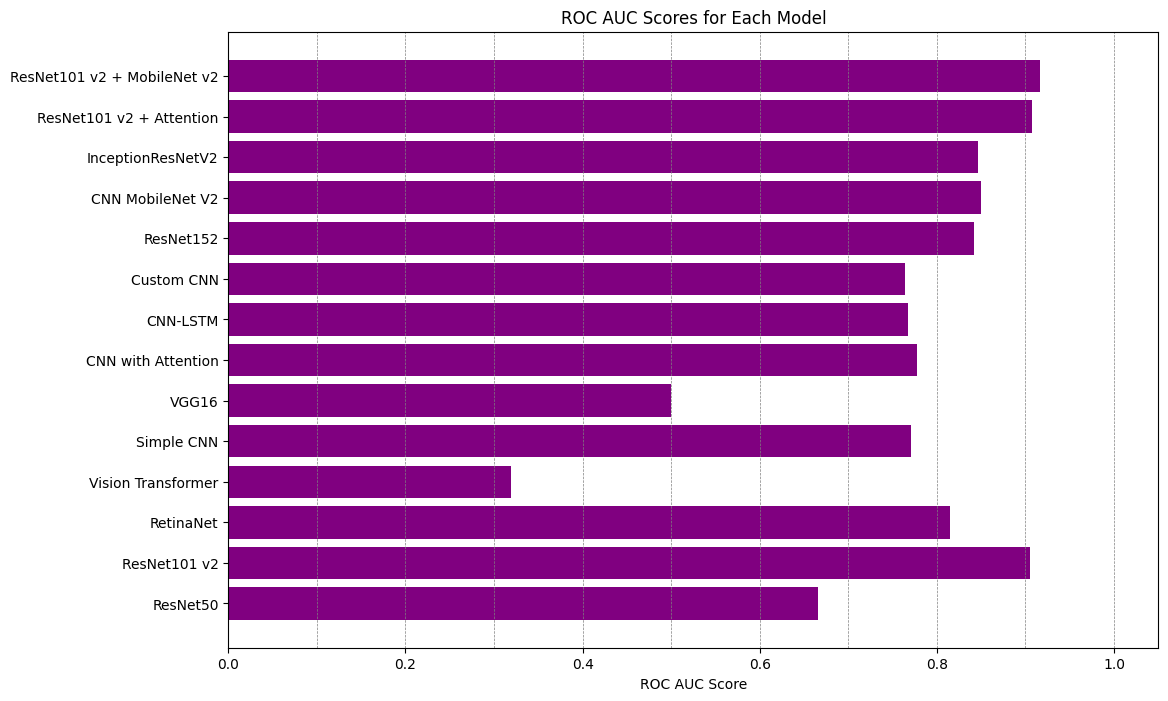

In [ ]:
roc_aucs = [0.666, 0.905, 0.815, 0.319, 0.771, 0.500, 0.777, 0.767, 0.764, 0.842, 0.850, 0.846, 0.907, 0.916]

plt.figure(figsize=(12, 8))
plt.barh(models, roc_aucs, color='purple')
plt.xlabel('ROC AUC Score')
plt.title('ROC AUC Scores for Each Model')

# Add dotted lines for every 0.1 increment in ROC AUC
for i in np.arange(0.1, 1.1, 0.1):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)

plt.show()
